In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transactions-data-bank-fraud-detection/Fraud.csv


In [2]:
fraud_df = pd.read_csv("/kaggle/input/transactions-data-bank-fraud-detection/Fraud.csv", parse_dates=["Date"])

/tmp/ipykernel_18/2485261295.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fraud_df = pd.read_csv("/kaggle/input/transactions-data-bank-fraud-detection/Fraud.csv", parse_dates=["Date"])


In [3]:
fraud_df.head()

,Date,nameOrig,amount,oldbalanceOrg,newbalanceOrig,City,type,Card Type,Exp Type,Gender,isFraud
0,2013-05-26,C2011200430,242.0,302.0,60.0,"Ahmedabad, India",TRANSFER,Gold,Food,F,1
1,2012-07-26,C931301500,7081.0,46066.0,38985.0,"Delhi, India",TRANSFER,Gold,Entertainment,M,1
2,2012-04-12,C963642457,16355.0,30355.0,14000.0,"Kolkata, India",TRANSFER,Silver,Fuel,F,1
3,2012-01-28,C1439438217,20820.0,39663.0,18843.0,"Lucknow, India",TRANSFER,Gold,Food,F,1
4,2014-04-16,C892940485,6071.0,35586.0,29515.0,"Bengaluru, India",TRANSFER,Gold,Fuel,M,1


In [4]:
fraud_df.describe()

,Date,amount,oldbalanceOrg,newbalanceOrig,isFraud
count,1048574,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06
mean,2013-02-26 19:18:36.892847104,3.802767e+04,8.801983e+05,8.421706e+05,1.676420e-01
min,2011-10-09 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2012-06-18 00:00:00,6.470000e+02,4.343812e+03,9.180000e+02,0.000000e+00
50%,2013-02-26 00:00:00,8.263000e+03,3.653918e+04,2.055200e+04,0.000000e+00
75%,2013-11-05 00:00:00,2.365000e+04,1.366425e+05,9.030729e+04,0.000000e+00
max,2015-05-26 00:00:00,1.000000e+07,3.890000e+07,3.889319e+07,1.000000e+00
std,NaN,1.105168e+05,2.969968e+06,2.936373e+06,3.735482e-01


### Split Train/Test Data

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

In [6]:
# create train_test

X_train_val, X_test = train_test_split(fraud_df, test_size=0.1, random_state=42)

## Data Inspection

In [7]:
## missing values

X_train_val.isna().any()

Date              False
nameOrig          False
amount            False
oldbalanceOrg     False
newbalanceOrig    False
City              False
type              False
Card Type         False
Exp Type          False
Gender            False
isFraud           False
dtype: bool

In [8]:
## duplicated rows

X_train_val.duplicated().any()

False

In [9]:
## Information on columns

X_train_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 943716 entries, 979635 to 121958
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            943716 non-null  datetime64[ns]
 1   nameOrig        943716 non-null  object        
 2   amount          943716 non-null  float64       
 3   oldbalanceOrg   943716 non-null  float64       
 4   newbalanceOrig  943716 non-null  float64       
 5   City            943716 non-null  object        
 6   type            943716 non-null  object        
 7   Card Type       943716 non-null  object        
 8   Exp Type        943716 non-null  object        
 9   Gender          943716 non-null  object        
 10  isFraud         943716 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 86.4+ MB


In [10]:
#Get numerical and categorical columns for analysis

cat_cols = X_train_val.select_dtypes("object").columns.tolist()[1:]
num_cols = X_train_val.select_dtypes(include=np.number).columns.tolist()

In [11]:
# print categories in categorical columns

def view_cat_cols(df, cols):
    for col in cols:
        print("*************************")
        print(df[col].value_counts(normalize=True))
        print("*************************")

In [12]:
view_cat_cols(X_train_val, cat_cols)

*************************
City
Bengaluru, India          0.137102
Ahmedabad, India          0.134784
Greater Mumbai, India     0.134722
Delhi, India              0.134339
Hyderabad, India          0.029883
                            ...   
Fazilka, India            0.000036
Bagaha, India             0.000036
Hugli-Chinsurah, India    0.000036
Godhra, India             0.000035
Varanasi, India           0.000033
Name: proportion, Length: 986, dtype: float64
*************************
*************************
type
CASH_OUT    0.356303
PAYMENT     0.337705
CASH_IN     0.216306
TRANSFER    0.082779
DEBIT       0.006907
Name: proportion, dtype: float64
*************************
*************************
Card Type
Silver       0.262785
Signature    0.247563
Platinum     0.245313
Gold         0.244187
Classic      0.000076
Mass         0.000076
Name: proportion, dtype: float64
*************************
*************************
Exp Type
Food              0.209876
Fuel              0.201923
B

In [13]:
## Create new column
X_train_val["location"] = X_train_val["City"].apply(lambda X: X.split(" ")[0].split(",")[0])

In [14]:
cat_cols.append("location")
view_cat_cols(X_train_val, cat_cols)

*************************
City
Bengaluru, India          0.137102
Ahmedabad, India          0.134784
Greater Mumbai, India     0.134722
Delhi, India              0.134339
Hyderabad, India          0.029883
                            ...   
Fazilka, India            0.000036
Bagaha, India             0.000036
Hugli-Chinsurah, India    0.000036
Godhra, India             0.000035
Varanasi, India           0.000033
Name: proportion, Length: 986, dtype: float64
*************************
*************************
type
CASH_OUT    0.356303
PAYMENT     0.337705
CASH_IN     0.216306
TRANSFER    0.082779
DEBIT       0.006907
Name: proportion, dtype: float64
*************************
*************************
Card Type
Silver       0.262785
Signature    0.247563
Platinum     0.245313
Gold         0.244187
Classic      0.000076
Mass         0.000076
Name: proportion, dtype: float64
*************************
*************************
Exp Type
Food              0.209876
Fuel              0.201923
B

- No empty or duplicated rows
- Data has been processed and in right format

## EDA

In [15]:
# import chart libraries

import matplotlib

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

params = {
    'figure.figsize': [10, 6],
    'axes.titlesize': 10,
    'axes.labelsize': 8
}

matplotlib.rcParams.update(params)

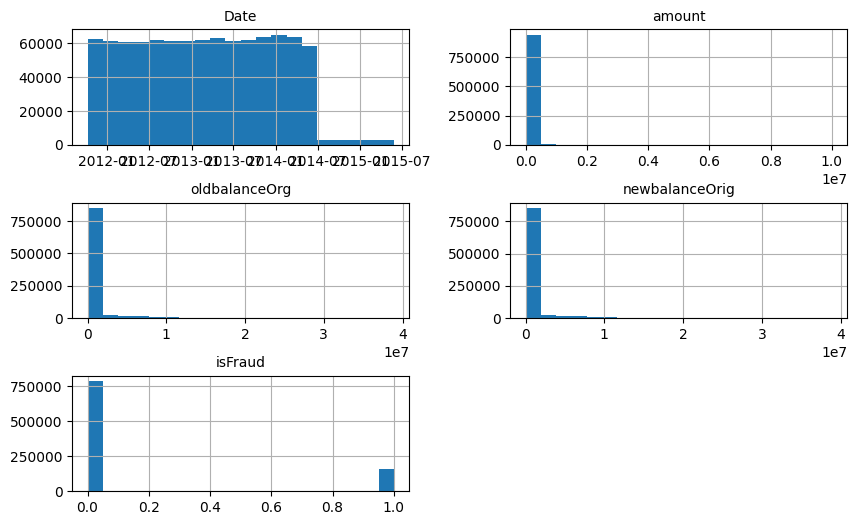

In [16]:
X_train_val.hist(bins=20)
plt.subplots_adjust(hspace=0.5)
plt.xticks(rotation=45)
plt.show()

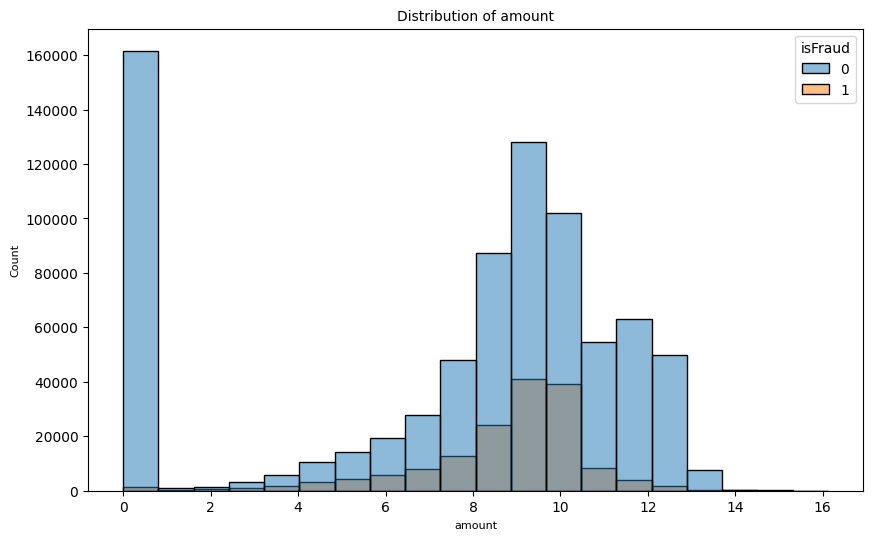

In [17]:
# distribution of the amount

sns.histplot(X_train_val, x=np.log1p(X_train_val["amount"]), bins=20, hue="isFraud")
plt.title("Distribution of amount")
plt.show()

- We transform the highly skewed data using nlog1 to get a more general view on the variable
- We use np.log1p as it handles zero values gracefully

In [18]:
percentage_diff = abs((X_train_val["newbalanceOrig"] - X_train_val["oldbalanceOrg"]) / X_train_val["oldbalanceOrg"]) * 100

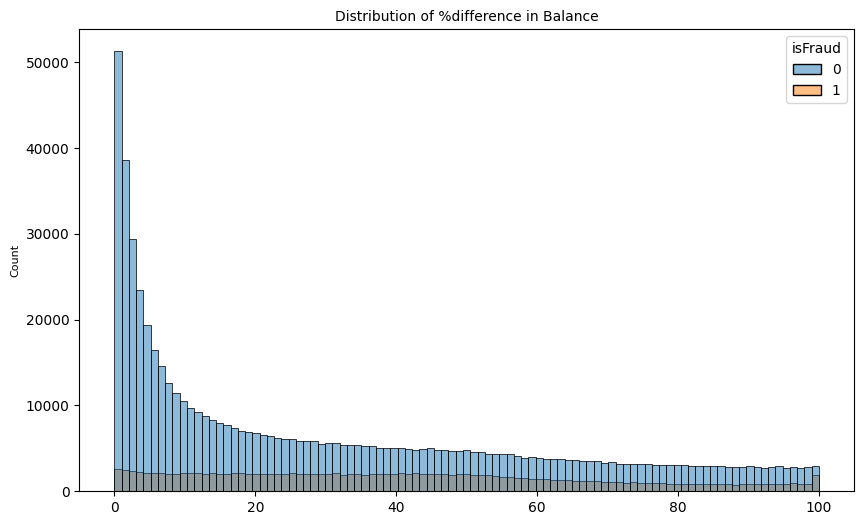

In [19]:
sns.histplot(X_train_val, x=percentage_diff, hue="isFraud", common_norm=True)
plt.title("Distribution of %difference in Balance")
plt.show()

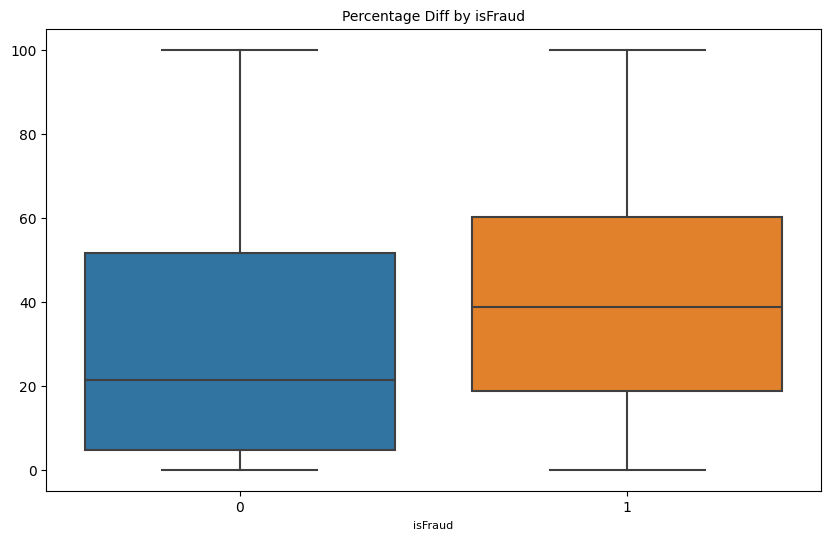

In [20]:
#boxplot of %diff in balance

sns.boxplot(X_train_val, x="isFraud", y=percentage_diff)
plt.title("Percentage Diff by isFraud")
plt.show()

- Balance Difference that are higher tend to be classified as fraudulent
- 40% change seems to the average threshold for Fraudulent transactions

<Axes: xlabel='type'>

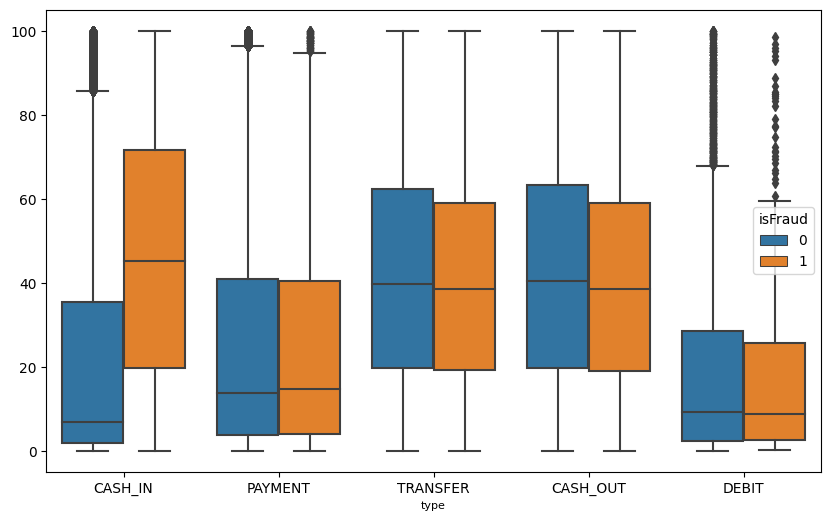

In [21]:
sns.boxplot(X_train_val, x="type", y=percentage_diff, hue="isFraud")

- Transaction with type "CASH-IN" and high difference ratio is likely to be fraudulent as show depicted above
- We can Create a column that classifies CASH-IN with high %diffence and others 

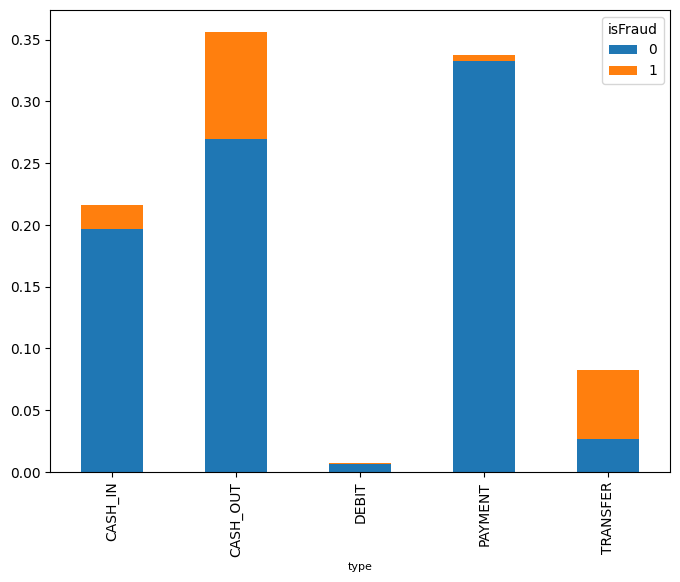

In [22]:
# Investigate Contigency Tables of Columns

freq = pd.crosstab(X_train_val["type"], X_train_val["isFraud"])
proportions = freq/len(X_train_val)

proportions.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.show()

- Seems Transfer Transactions are more likely to be Fraudulent
- We can investigate further

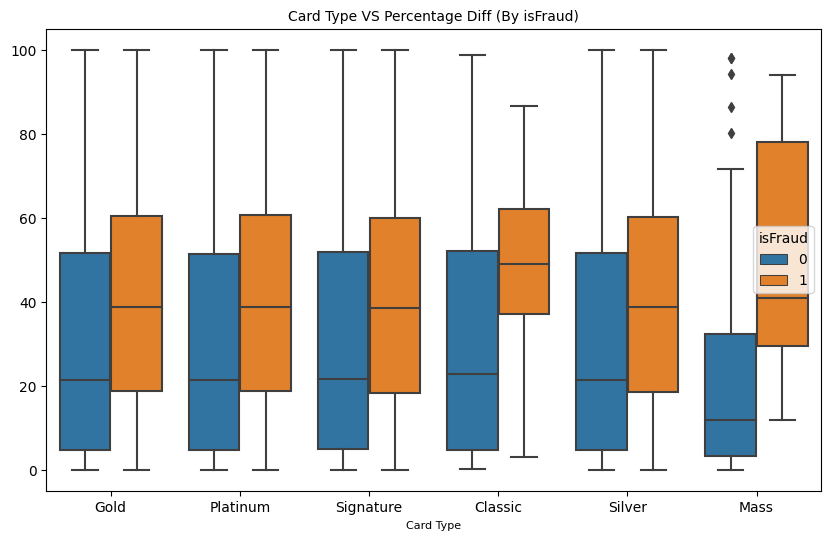

In [23]:
sns.boxplot(X_train_val, x="Card Type", y=percentage_diff, hue="isFraud")
plt.title("Card Type VS Percentage Diff (By isFraud)")
plt.show()

- We can see that when the Card type is "Mass" and the percentage difference in balance is high, it's most likely to be a fraudulent transaction
- Create a categorical column for this as well

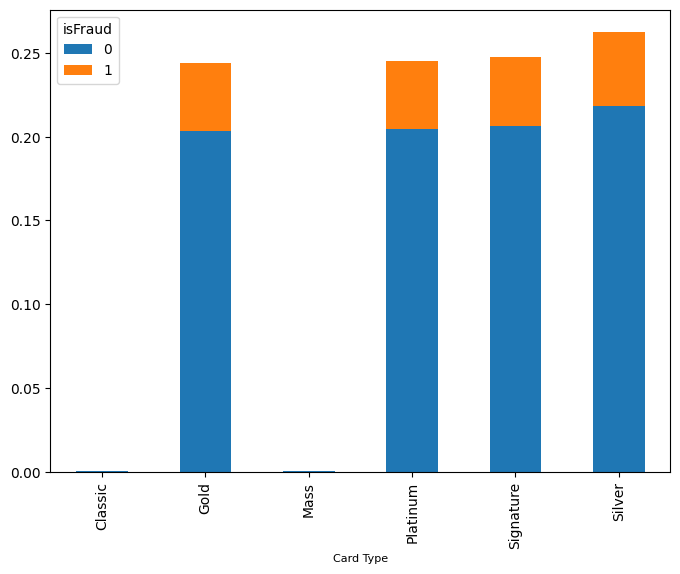

In [24]:
# Investigate Contigency Tables of Columns

freq = pd.crosstab(X_train_val["Card Type"], X_train_val["isFraud"])
proportions = freq/len(X_train_val)

proportions.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.show()

### Split Train/Val Data

In [25]:
X_train, X_val = train_test_split(X_train_val, test_size=0.2, random_state=42)